In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import xarray as xr
import numpy as np
from glob import glob
from yllib.function import mysom
from yllib.function import myfunc
from yllib.plot import plot_map
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format='retina'
%matplotlib inline

In [2]:
year1   = 1981
year2   = 2020
cold_months  = [10,11,12,1,2,3]
warm_months  = [4,5,6,7,8,9]
mapsize = (4,4)
factor  = ('z')
map_extent = [-125+360,-70+360,25,50]
sig_level = 0.95

## Load ERA5 and reconstructed winds on the monthly basis

In [3]:
# read patterns
era_cold = xr.open_dataset(f'reconstruct/era5/ano_cold.31D.nc')['ano']
era_warm = xr.open_dataset(f'reconstruct/era5/ano_warm.31D.nc')['ano']

est_cold  = xr.open_dataset(f'reconstruct/ano_est/estimated_wind_cold_{mapsize[0]}x{mapsize[1]}.31D.nc')['ano_est']
est_warm  = xr.open_dataset(f'reconstruct/ano_est/estimated_wind_warm_{mapsize[0]}x{mapsize[1]}.31D.nc')['ano_est']

# ds = xr.open_dataset(f'som/hgt_ano_warm_{mapsize[0]}x{mapsize[1]}.nc')
# ano_warm = ds['ano'].sel(variable='z500')
# # ano_warm = ano_warm.sel(latitude=slice(*map_extent[2:][::-1]), longitude=slice(*map_extent[:2]))


In [4]:
est_cold.time[:12]

<xarray.DataArray 'time' (time: 12)>
array(['1981-01-01T00:00:00.000000000', '1981-02-01T00:00:00.000000000',
       '1981-03-04T00:00:00.000000000', '1981-10-07T00:00:00.000000000',
       '1981-11-07T00:00:00.000000000', '1981-12-08T00:00:00.000000000',
       '1982-01-01T00:00:00.000000000', '1982-02-01T00:00:00.000000000',
       '1982-03-04T00:00:00.000000000', '1982-10-07T00:00:00.000000000',
       '1982-11-07T00:00:00.000000000', '1982-12-08T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 1982-12-08

In [5]:
era_cold = era_cold.dropna(dim='time', how='all')
era_cold = era_cold.sel(time=era_cold['time.month']!=9)
era_cold.time[:12]

<xarray.DataArray 'time' (time: 12)>
array(['1981-01-01T00:00:00.000000000', '1981-02-01T00:00:00.000000000',
       '1981-03-04T00:00:00.000000000', '1981-10-07T00:00:00.000000000',
       '1981-11-07T00:00:00.000000000', '1981-12-08T00:00:00.000000000',
       '1982-01-01T00:00:00.000000000', '1982-02-01T00:00:00.000000000',
       '1982-03-04T00:00:00.000000000', '1982-10-07T00:00:00.000000000',
       '1982-11-07T00:00:00.000000000', '1982-12-08T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 1982-12-08

In [6]:
era_warm

<xarray.DataArray 'ano' (variable: 4, time: 240, latitude: 141, longitude: 361)>
[48864960 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 1981-04-01 1981-05-02 ... 2020-09-03
  * latitude   (latitude) float64 55.0 54.75 54.5 54.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 220.0 220.2 220.5 220.8 ... 309.5 309.8 310.0
  * variable   (variable) object 'VAR_100UV' 'power1' 'power2' 'power3'

In [7]:
est_warm

<xarray.DataArray 'ano_est' (variable: 4, latitude: 141, longitude: 361,
                             time: 240)>
[48864960 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float64 55.0 54.75 54.5 54.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 220.0 220.2 220.5 220.8 ... 309.5 309.8 310.0
  * variable   (variable) object 'VAR_100UV' 'power1' 'power2' 'power3'
  * time       (time) datetime64[ns] 1981-04-01 1981-05-02 ... 2020-09-03

## Plot spearman correlation for wind speed

In [8]:
r, p = [], []
for i in np.arange(1,13):
    if i in [10,11,12,1,2,3]:
        _era = era_cold.sel(time=era_cold['time.month']==i, variable='VAR_100UV')
        _est = est_cold.sel(time=est_cold['time.month']==i, variable='VAR_100UV')
    else:
        _era = era_warm.sel(time=era_warm['time.month']==i, variable='VAR_100UV')
        _est = est_warm.sel(time=est_warm['time.month']==i, variable='VAR_100UV')
    _r, _p = myfunc.sci_spearmanr(_est, _era)
    # _r, _p = myfunc.sci_pearsonr(_est, _era)
    r.append(_r)
    p.append(_p)
r = xr.concat(r, dim='month')
p = xr.concat(p, dim='month')

### plot

In [10]:
def mask_keep_us(data):
    mask = xr.open_dataset("mask_us.nc")["mask"]
    mask = mask.sel(latitude=data.latitude, longitude=data.longitude)
    data.coords["mask"] = mask
    data = data.where(mask==1)
    del data.coords["mask"]
    return data

def plot_on_map(data, dot=None, **kwargs):
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'Helvetica'  
    
    # create a figure
    if (fig:=kwargs.get('fig')) is None:  
        fig = plt.figure(figsize=(8, 5))
    if (ax:=kwargs.get('ax')) is None:  ax = plt.axes()
    ax.set_axis_on()
    
    # set map - extent, grid, coastline ...
    plot_map.set_map(
        ax,
        extent=[-125+360,-70+360,25,50],
        # extent=[0,360,15,90],
        gridlines_kw=dict(
            xticks=[-120,-100,-80,-60],
            yticks=[20,30,40],
            linestyle=":", alpha=0.3,
        ),
        gridlabels_kw=dict(
            xticks=[],
            yticks=[],
        ),
        boundary_kw=dict(
            draw_state=True,
            coastline_kw=dict(linewidth=0.9, alpha=0.7, color='k'),
            draw_borders=True,
            border_kw=dict(linewidth=0.9, alpha=0.7, color='k'),
        ),
    )
    
    # lat and lon for contour plot
    lon, lat = data["longitude"], data["latitude"]
    
    # draw contourf
    cmap = kwargs.get('cmap', "WhiteBlueGreenYellowRed")
    clev = kwargs.get('clev', np.arange(0, 40, 1))
    cs, clev = plot_map.add_contourf(
        ax, lon, lat, data,
        cmap=cmap,clev=clev,
    )
    
    if dot is not None:
        _, _ = plot_map.add_hatches(ax,
                        lon, lat, dot,
                        clev=[0, 0.05],
                        hatches=["..."],
                        color="tab:gray",
                       )
    
    # draw contour
#     xclev = [-90,-70,-50,-30,-10, 10,30,50,70,90]
#     plot_map.add_contour(
#         ax, lon, lat, data,
#         colors=['k'], clev=xclev, alpha=0.7, linewidths=1.0,
#     )
    
    
    # add text - title, ananote
    if (title:=kwargs.get('title')) is not None: 
        default_title_kwargs = dict(loc='left')
        default_title_kwargs.update(kwargs.get('title_kwargs', {}))
        ax.set_title(title, **default_title_kwargs)

    if kwargs.get('draw_colorbar'):
        plot_map.add_colorbar(cs, ax, clev[::10])
        
    return cs, clev

- pre-process for ploltting

In [11]:
r = mask_keep_us(r)
p = mask_keep_us(p)

- plot

/people/liuy351/software/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


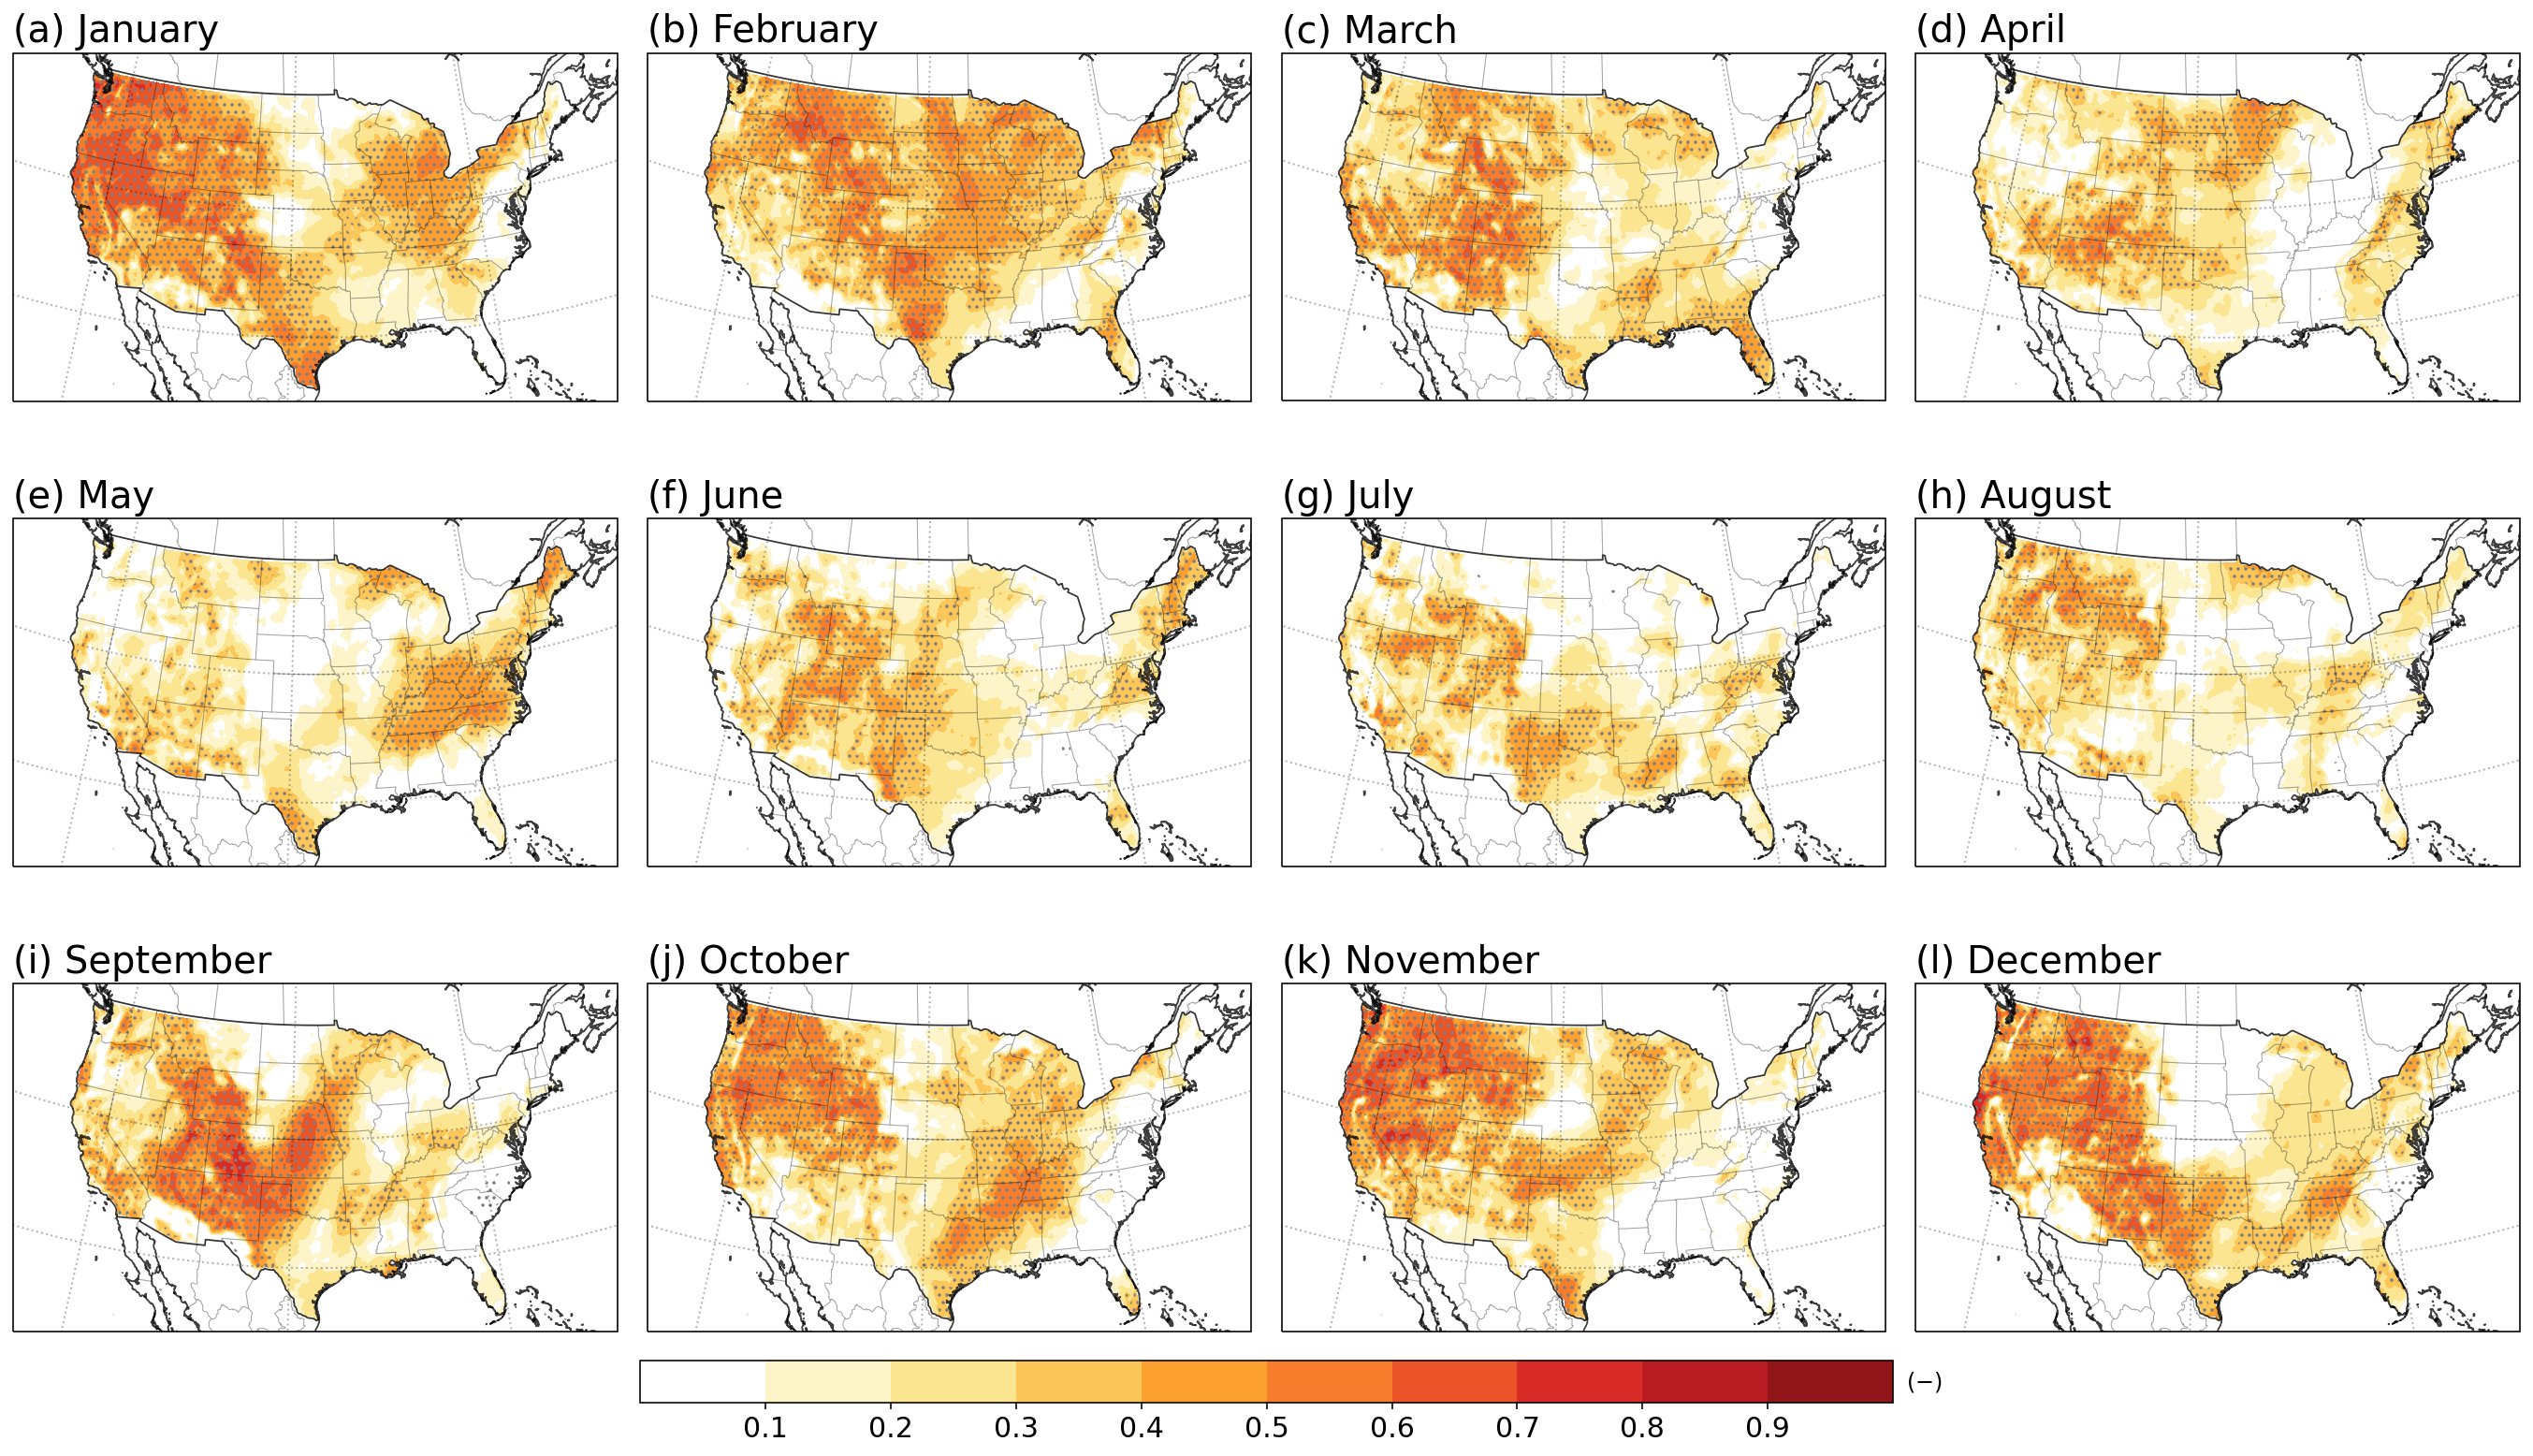

In [13]:
central_lon = np.mean(map_extent[:2])
central_lat = np.mean(map_extent[2:])
projection  = ccrs.AlbersEqualArea(central_lon, central_lat)
fig, axs = plt.subplots(
    3, 4, figsize=(20, 12), 
    subplot_kw={'projection': projection}
)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.1, wspace=0.05)
axs = axs.ravel()
abcd = list('abcdefghijklmn')
monstr = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']# abcd = list('abcdefghijklmnop')
# for ax in axs: ax.set_axis_off()
for i in np.arange(12):
    ax = axs[i]
    cs, clev = plot_on_map(
        r.isel(month=i),
        p.isel(month=i),
        fig=fig, ax=ax,
        clev=[-100]+list(np.linspace(0.1,0.9,9))+[100],
        cmap='WhiteYellowOrangeRed',
        title=f'({abcd[i]}) {monstr[i]}',
        title_kwargs=dict(fontsize=20),
    )

plot_map.add_colorbar(cs, axs, clev[1:-1:1], pad=0.02, shrink=0.5, units="$(-)$")


## Plot standard deviation ratio

In [14]:
rstd = []
for i in np.arange(1,13):
    if i in [10,11,12,1,2,3]:
        _era = era_cold.sel(time=era_cold['time.month']==i, variable='VAR_100UV')
        _est = est_cold.sel(time=est_cold['time.month']==i, variable='VAR_100UV')
    else:
        _era = era_warm.sel(time=era_warm['time.month']==i, variable='VAR_100UV')
        _est = est_warm.sel(time=est_warm['time.month']==i, variable='VAR_100UV')
    std_era = _era.std('time')
    std_est = _est.std('time')
    _rstd = std_est / std_era
    rstd.append(_rstd)
rstd = xr.concat(rstd, dim='month')

In [15]:
rstd = mask_keep_us(rstd)

/people/liuy351/software/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


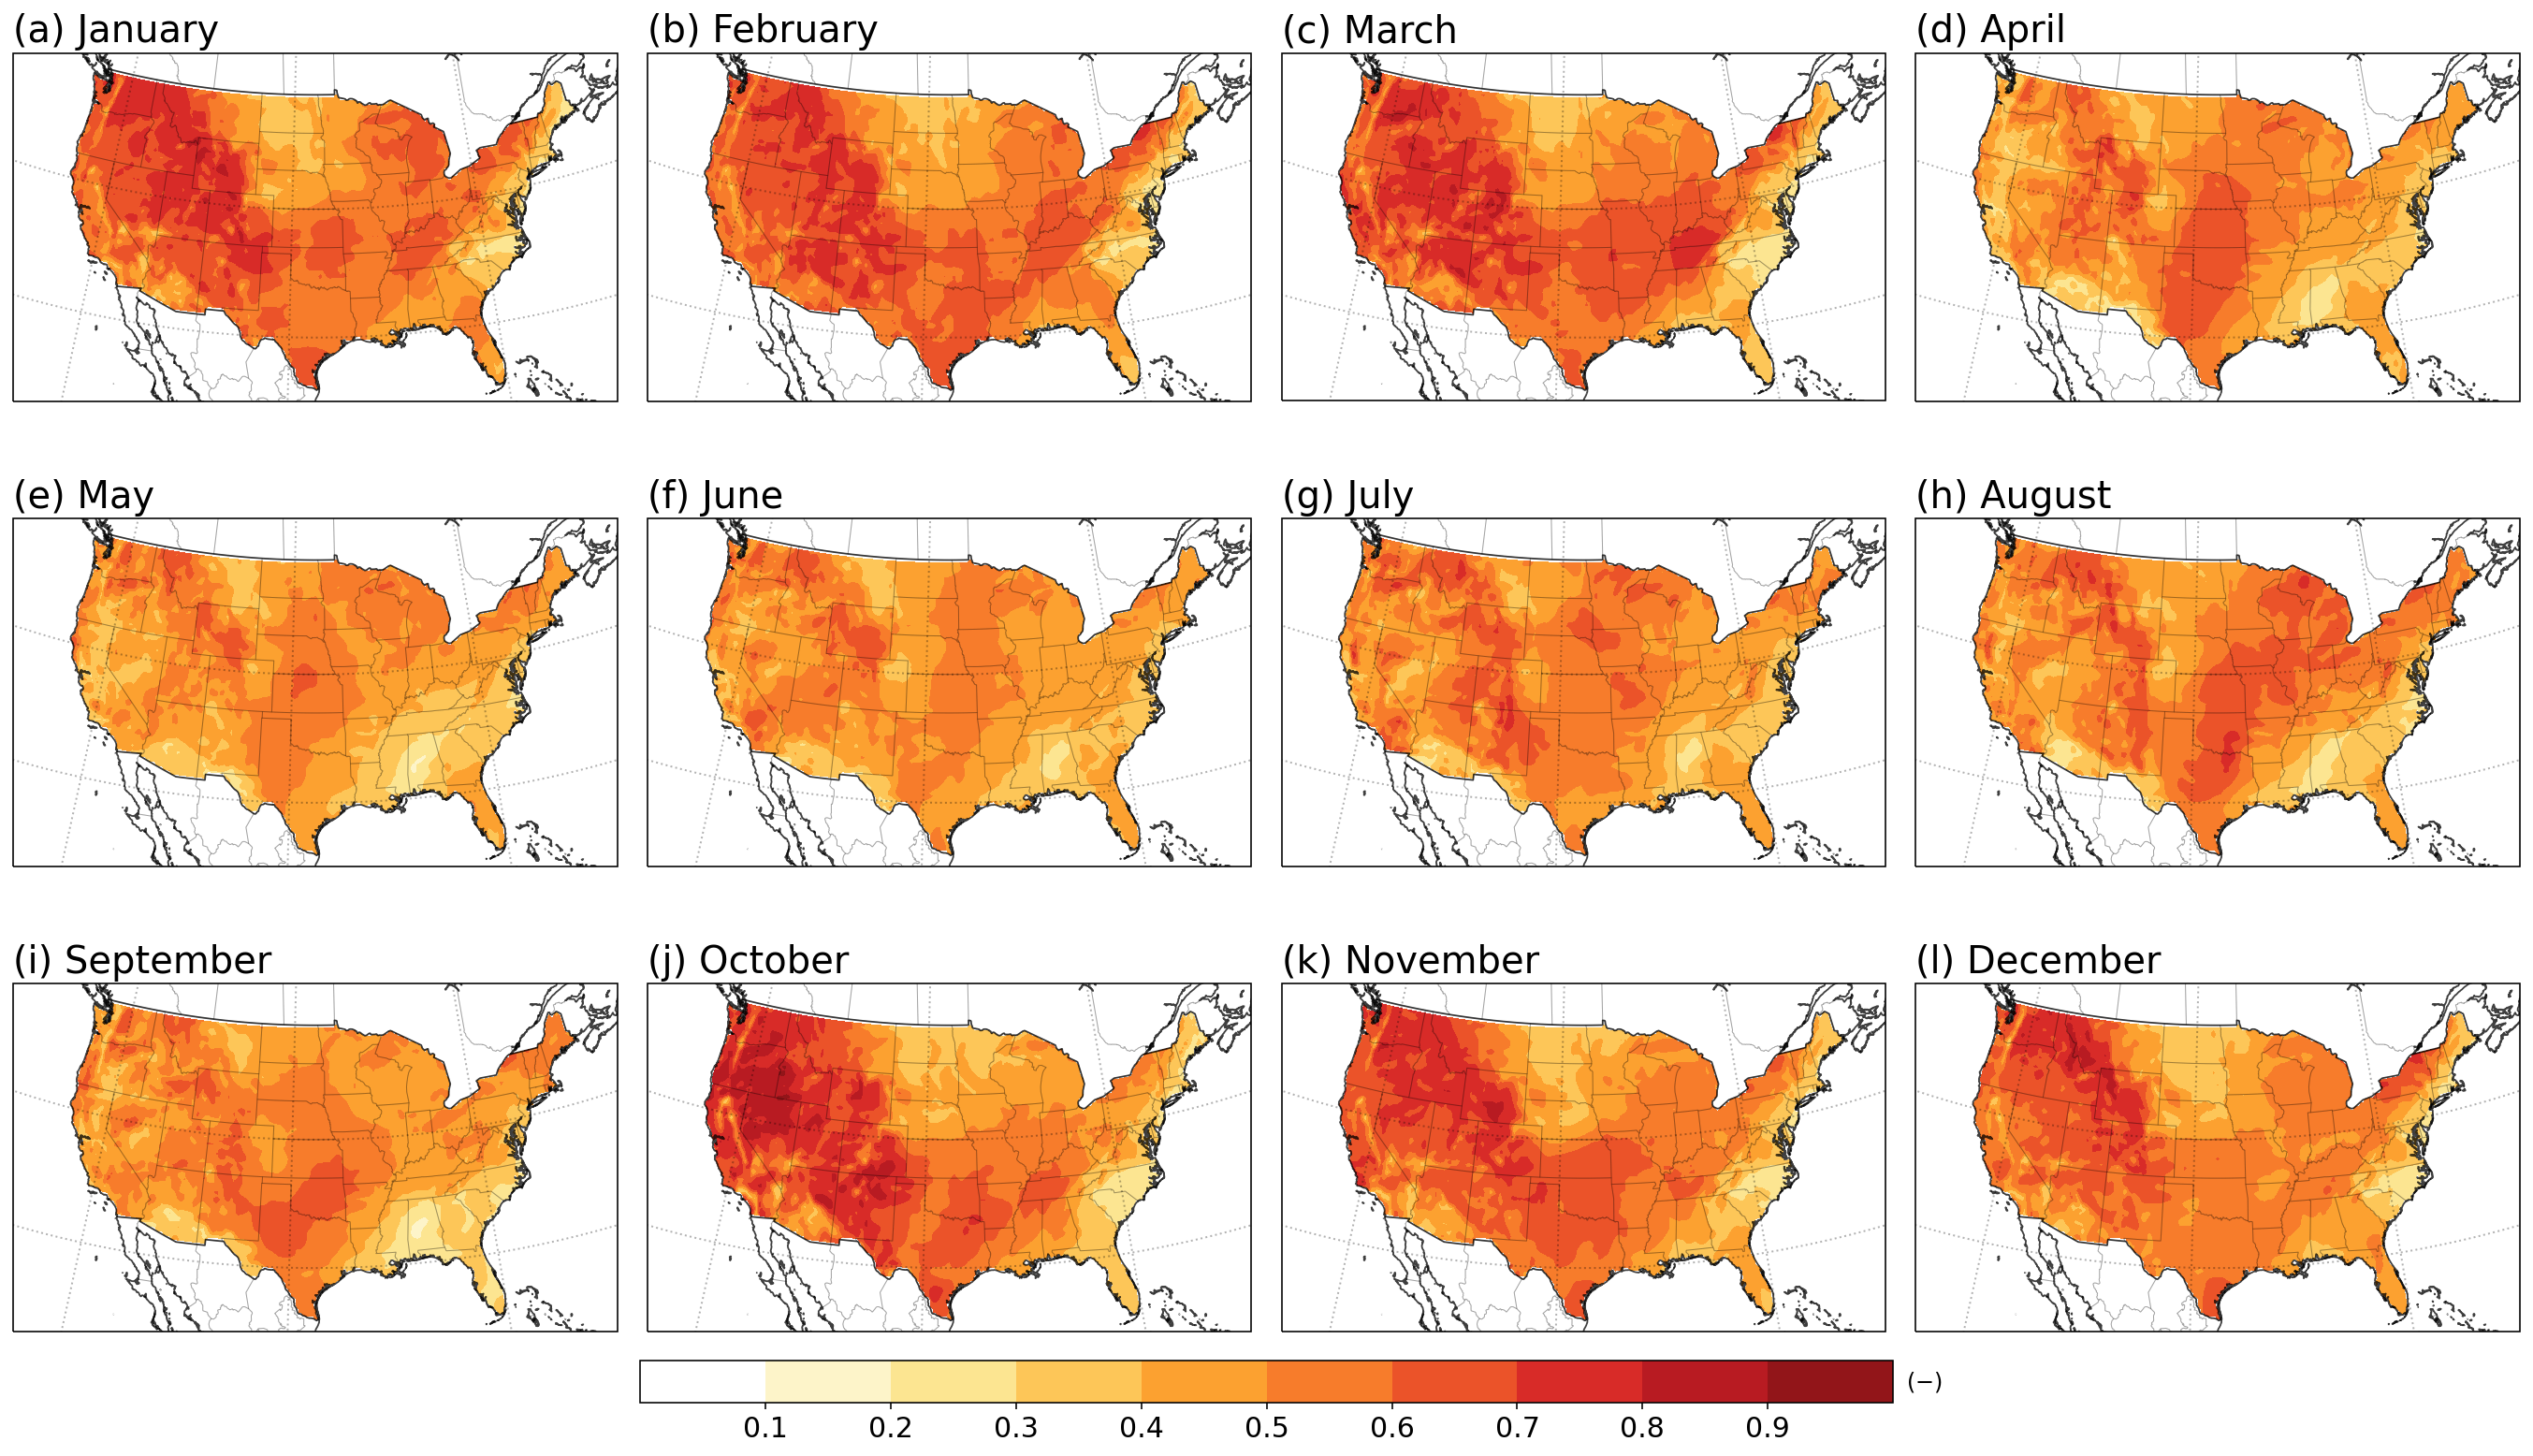

In [16]:
central_lon = np.mean(map_extent[:2])
central_lat = np.mean(map_extent[2:])
projection  = ccrs.AlbersEqualArea(central_lon, central_lat)
fig, axs = plt.subplots(
    3, 4, figsize=(20, 12), 
    subplot_kw={'projection': projection}
)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.1, wspace=0.05)
axs = axs.ravel()
abcd = list('abcdefghijklmn')
monstr = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']# abcd = list('abcdefghijklmnop')

for i in np.arange(12):
    ax = axs[i]
    _disp = rstd.isel(month=i)
    cs, clev = plot_on_map(
        _disp,
        fig=fig, ax=ax,
        clev=[-100]+list(np.linspace(0.1,0.9,9))+[100],
        cmap='WhiteYellowOrangeRed',
        title=f'({abcd[i]}) {monstr[i]}',
        title_kwargs=dict(fontsize=20),
    )

plot_map.add_colorbar(cs, axs, clev[1:-1:1], pad=0.02, shrink=0.5, units="$(-)$")